# Pareto Front: Assess All Feasible Solutions for a Patient

For a given patient, generate all feasible surgical plans and score them using both:
- Mechanical Failure Risk Model
- Composite Score Model

## Setup and Load Models

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import pandas as pd
import joblib

import src.optimization_utils as ou
from src import config

# Load models
bundle_mech_fail = joblib.load("../artifacts/mech_fail_xgb.joblib")
bundle_composite = joblib.load("../artifacts/composite_score_model.joblib")

print("Mechanical Failure Model:", bundle_mech_fail["model_name"])
print("Composite Score Model:", bundle_composite["model_name"])
print()
print(f"Mech Fail Features ({len(bundle_mech_fail['features'])}): {bundle_mech_fail['features']}")
print(f"Composite Features ({len(bundle_composite['features'])}): {bundle_composite['features']}")

Mechanical Failure Model: mech_fail_xgb
Composite Score Model: composite_histgb_reg

Mech Fail Features (23): ['age', 'sex', 'PI_preop', 'PT_preop', 'LL_preop', 'SS_preop', 'T4PA_preop', 'L1PA_preop', 'SVA_preop', 'cobb_main_curve_preop', 'FC_preop', 'tscore_femneck_preop', 'HU_UIV_preop', 'HU_UIVplus1_preop', 'HU_UIVplus2_preop', 'UIV_implant', 'num_interbody_fusion_levels', 'ALIF', 'XLIF', 'TLIF', 'num_rods', 'num_pelvic_screws', 'osteotomy']
Composite Features (23): ['age', 'sex', 'PI_preop', 'PT_preop', 'LL_preop', 'SS_preop', 'T4PA_preop', 'L1PA_preop', 'SVA_preop', 'cobb_main_curve_preop', 'FC_preop', 'tscore_femneck_preop', 'HU_UIV_preop', 'HU_UIVplus1_preop', 'HU_UIVplus2_preop', 'UIV_implant', 'num_interbody_fusion_levels', 'ALIF', 'XLIF', 'TLIF', 'num_rods', 'num_pelvic_screws', 'osteotomy']


## Get Decision Space (Feasible Solutions)

In [2]:
# Get decision variable bounds and UIV choices
UIV_CHOICES, xl, xu = ou.get_decision_config()

print("Decision Variable Bounds:")
print(pd.DataFrame([xl, xu], index=["lower_bound","upper_bound"], columns=config.PLAN_COLS))

Decision Variable Bounds:
             UIV_implant  num_interbody_fusion_levels  ALIF  XLIF  TLIF  \
lower_bound            0                            0     0     0     0   
upper_bound            2                            5     1     1     1   

             num_rods  num_pelvic_screws  osteotomy  
lower_bound         1                  1          0  
upper_bound         6                  6          1  


## Select a Patient

In [3]:
df = pd.read_csv(config.DATA_INTERMEDIATE)
df.columns = df.columns.astype(str).str.replace("\n"," ").str.replace(r"\s+"," ", regex=True).str.strip()

print(f"Loaded {len(df)} patients")
print(f"Predictors ({len(config.PREDICTORS)}): {config.PREDICTORS}")

Loaded 277 patients
Predictors (15): ['age', 'sex', 'PI_preop', 'PT_preop', 'LL_preop', 'SS_preop', 'T4PA_preop', 'L1PA_preop', 'SVA_preop', 'cobb_main_curve_preop', 'FC_preop', 'tscore_femneck_preop', 'HU_UIV_preop', 'HU_UIVplus1_preop', 'HU_UIVplus2_preop']


In [4]:
# Select patient by index
patient_idx = 2

if patient_idx < 0 or patient_idx >= len(df):
    print(f"Error: patient_idx {patient_idx} out of range (0-{len(df)-1})")
else:
    patient_row = df.iloc[patient_idx]
    patient_fixed = patient_row[config.PREDICTORS].to_dict()
    print(f"Patient Index: {patient_idx}")
    print(f"Patient Demographics (Predictors):")
    for k, v in patient_fixed.items():
        print(f"  {k}: {v}")


Patient Index: 2
Patient Demographics (Predictors):
  age: 82
  sex: FEMALE
  PI_preop: 37.5
  PT_preop: 22.0
  LL_preop: 13.0
  SS_preop: 15.5
  T4PA_preop: 23.6
  L1PA_preop: 5.8
  SVA_preop: 136.5
  cobb_main_curve_preop: 16.2
  FC_preop: 12.0
  tscore_femneck_preop: nan
  HU_UIV_preop: 138.0
  HU_UIVplus1_preop: 137.0
  HU_UIVplus2_preop: 136.0


## Generate All Feasible Solutions

In [5]:
from itertools import product

ranges = [range(int(xl[i]), int(xu[i]) + 1) for i in range(len(xl))]
solutions = np.array([np.array(combo) for combo in product(*ranges)])

range_sizes = [len(r) for r in ranges]
total_combos = 1
for size in range_sizes:
    total_combos *= size

print("Decision Variable Ranges:")
for i, (name, size) in enumerate(zip(config.PLAN_COLS, range_sizes)):
    print(f"  {name}: {range_sizes[i]} options")

print(f"\nTotal combinations: {' × '.join(map(str, range_sizes))} = {total_combos}")
print(f"Total feasible solutions: {len(solutions)}")
print(f"Sample first 5 solutions:\n{solutions[:5]}")

Decision Variable Ranges:
  UIV_implant: 3 options
  num_interbody_fusion_levels: 6 options
  ALIF: 2 options
  XLIF: 2 options
  TLIF: 2 options
  num_rods: 6 options
  num_pelvic_screws: 6 options
  osteotomy: 2 options

Total combinations: 3 × 6 × 2 × 2 × 2 × 6 × 6 × 2 = 10368
Total feasible solutions: 10368
Sample first 5 solutions:
[[0 0 0 0 0 1 1 0]
 [0 0 0 0 0 1 1 1]
 [0 0 0 0 0 1 2 0]
 [0 0 0 0 0 1 2 1]
 [0 0 0 0 0 1 3 0]]


## Score All Solutions with Both Models

In [6]:
def score_solution(x, patient_fixed, bundle_mech, bundle_comp, uiv_choices):
    plan = ou.decode_plan(x, uiv_choices)
    features_dict = {**patient_fixed, **plan}
    
    mech_fail_features = bundle_mech["features"]
    X_mech = pd.DataFrame([{c: features_dict.get(c, np.nan) for c in mech_fail_features}])
    mech_fail_risk = float(bundle_mech["pipe"].predict_proba(X_mech)[:, 1][0])
    
    comp_features = bundle_comp["features"]
    X_comp = pd.DataFrame([{c: features_dict.get(c, np.nan) for c in comp_features}])
    composite_score = float(bundle_comp["pipe"].predict(X_comp)[0])
    
    return mech_fail_risk, composite_score, plan

results = []
for i, x in enumerate(solutions):
    if i % 100 == 0:
        print(f"Scoring solution {i}/{len(solutions)}...")
    try:
        mech_risk, comp_score, plan = score_solution(x, patient_fixed, bundle_mech_fail, bundle_composite, UIV_CHOICES)
        result_row = {
            "uiv_code": int(x[0]),
            "num_interbody_fusion_levels": int(x[1]),
            "ALIF": int(x[2]),
            "XLIF": int(x[3]),
            "TLIF": int(x[4]),
            "num_rods": int(x[5]),
            "num_pelvic_screws": int(x[6]),
            "osteotomy": int(x[7]),
            "UIV_implant": plan.get("UIV_implant"),
            "mech_fail_risk": mech_risk,
            "composite_score": comp_score,
        }
        results.append(result_row)
    except Exception as e:
        print(f"  Error at solution {i}: {e}")

df_results = pd.DataFrame(results)
print(f"\nSuccessfully scored {len(df_results)} solutions")
print(f"\nResults summary:")
print(df_results[["mech_fail_risk", "composite_score"]].describe())

Scoring solution 0/10368...
Scoring solution 100/10368...
Scoring solution 200/10368...
Scoring solution 300/10368...
Scoring solution 400/10368...
Scoring solution 500/10368...
Scoring solution 600/10368...
Scoring solution 700/10368...
Scoring solution 800/10368...
Scoring solution 900/10368...
Scoring solution 1000/10368...
Scoring solution 1100/10368...
Scoring solution 1200/10368...
Scoring solution 1300/10368...
Scoring solution 1400/10368...
Scoring solution 1500/10368...
Scoring solution 1600/10368...
Scoring solution 1700/10368...
Scoring solution 1800/10368...
Scoring solution 1900/10368...
Scoring solution 2000/10368...
Scoring solution 2100/10368...
Scoring solution 2200/10368...
Scoring solution 2300/10368...
Scoring solution 2400/10368...
Scoring solution 2500/10368...
Scoring solution 2600/10368...
Scoring solution 2700/10368...
Scoring solution 2800/10368...
Scoring solution 2900/10368...
Scoring solution 3000/10368...
Scoring solution 3100/10368...
Scoring solution 320

## Identify Pareto Front

In [7]:
# A solution is on the Pareto front if:
# - We can't find another solution with BOTH lower risk AND lower composite score

def is_pareto_optimal(idx, risks, scores):
    my_risk = risks[idx]
    my_score = scores[idx]
    for i in range(len(risks)):
        if i != idx and risks[i] < my_risk and scores[i] < my_score:
            return False
    return True

risks = df_results["mech_fail_risk"].values
scores = df_results["composite_score"].values
pareto_mask = [is_pareto_optimal(i, risks, scores) for i in range(len(df_results))]
df_pareto = df_results[pareto_mask].copy().reset_index(drop=True)

print(f"Pareto front solutions: {len(df_pareto)} out of {len(df_results)}")

Pareto front solutions: 936 out of 10368


In [8]:
# Select diverse solutions from Pareto front using max-min distance algorithm
def select_diverse_solutions(df, n_select=12):
    """Select n diverse solutions from Pareto front using max-min distance."""
    if len(df) <= n_select:
        return df.copy()
    
    # Normalize objectives to [0,1] for distance calculation
    risk_min, risk_max = df["mech_fail_risk"].min(), df["mech_fail_risk"].max()
    score_min, score_max = df["composite_score"].min(), df["composite_score"].max()
    
    risk_norm = (df["mech_fail_risk"] - risk_min) / (risk_max - risk_min + 1e-9)
    score_norm = (df["composite_score"] - score_min) / (score_max - score_min + 1e-9)
    
    points = np.column_stack([risk_norm.values, score_norm.values])
    
    # Start with the two extreme points
    selected_idx = [df["mech_fail_risk"].idxmin(), df["composite_score"].idxmin()]
    selected_idx = list(set(selected_idx))  # Remove duplicates
    
    # Greedily add points that maximize minimum distance to selected set
    while len(selected_idx) < n_select:
        best_idx = None
        best_min_dist = -1
        
        for i in df.index:
            if i in selected_idx:
                continue
            # Calculate minimum distance to any selected point
            min_dist = min(np.linalg.norm(points[i] - points[j]) for j in selected_idx)
            if min_dist > best_min_dist:
                best_min_dist = min_dist
                best_idx = i
        
        if best_idx is not None:
            selected_idx.append(best_idx)
        else:
            break
    
    return df.loc[selected_idx].sort_values("mech_fail_risk").reset_index(drop=True)

n_select = 12
df_diverse = select_diverse_solutions(df_pareto, n_select=n_select)
print(f"Selected {len(df_diverse)} diverse solutions from {len(df_pareto)} Pareto-optimal plans")

Selected 12 diverse solutions from 936 Pareto-optimal plans


## Visualize Pareto Front

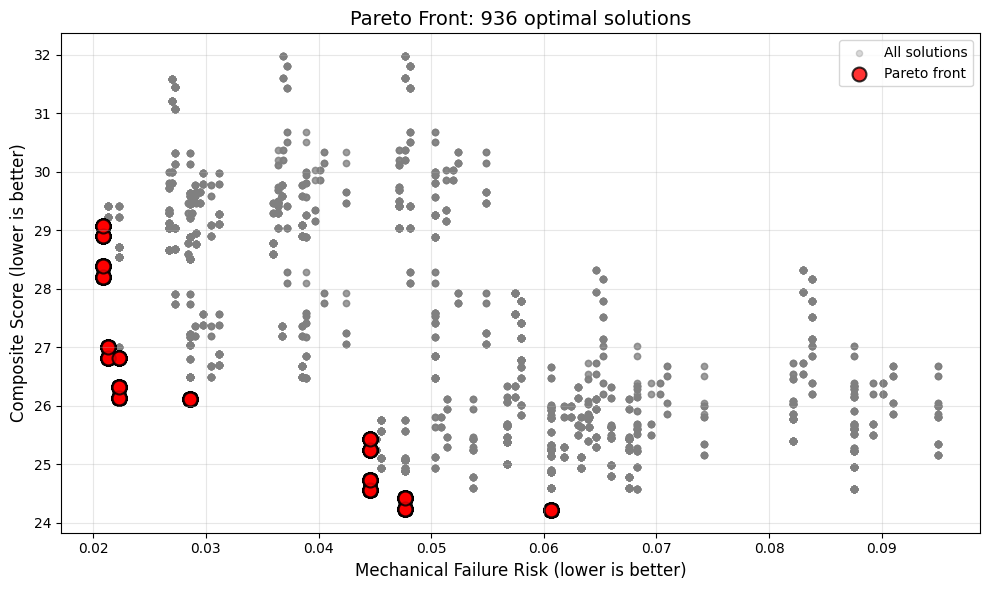

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df_results["mech_fail_risk"], df_results["composite_score"], 
          alpha=0.3, s=20, label="All solutions", color="gray")

# Plot Pareto front
ax.scatter(df_pareto["mech_fail_risk"], df_pareto["composite_score"], 
          alpha=0.8, s=100, label="Pareto front", color="red", edgecolors="black", linewidth=1.5)

ax.set_xlabel("Mechanical Failure Risk (lower is better)", fontsize=12)
ax.set_ylabel("Composite Score (lower is better)", fontsize=12)
ax.set_title(f"Pareto Front: {len(df_pareto)} optimal solutions", fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Display diverse solutions dataframe
print(f"Diverse Pareto-Optimal Solutions ({len(df_diverse)} plans):\n")
df_diverse

Diverse Pareto-Optimal Solutions (12 plans):



,uiv_code,num_interbody_fusion_levels,ALIF,XLIF,TLIF,num_rods,num_pelvic_screws,osteotomy,UIV_implant,mech_fail_risk,composite_score
0,1,4,0,0,0,4,3,0,PS,0.020836,28.898715
1,1,4,0,0,0,4,4,0,PS,0.020836,28.208784
2,1,4,0,0,0,4,3,1,PS,0.020836,29.081303
3,0,4,0,0,0,4,1,1,Hook,0.021290,27.008579
4,0,4,0,0,0,4,4,0,Hook,0.022307,26.136060
5,0,4,0,0,0,4,3,0,Hook,0.022307,26.825990
6,0,0,0,0,0,4,4,0,Hook,0.028590,26.116604
7,1,4,1,0,0,4,3,0,PS,0.044574,25.246952
8,1,4,1,0,0,4,4,1,PS,0.044574,24.739610
9,1,4,1,0,0,4,3,1,PS,0.044574,25.429541


## Patient Post-op Results


In [17]:
print(f"Patient {patient_idx} - Actual Outcomes:")
print("=" * 60)

# Mechanical Failure
mech_fail = df.iloc[patient_idx]['mech_fail_last']
print(f"Mechanical Failure: {'Yes' if mech_fail == 1 else 'No'}")
print()

# Gap Score comparison
print(f"{'Measurement':<25} {'Pre-op':<15} {'Post-op':<15}")
print("-" * 60)

gap_score_preop = df.iloc[patient_idx]['gap_score_preop']
gap_score_postop = df.iloc[patient_idx]['gap_score_postop']
print(f"{'Gap Score':<25}", end="")
print(f"{str(gap_score_preop):<15}", end="")
print(f"{str(gap_score_postop):<15}")

gap_cat_preop = df.iloc[patient_idx]['gap_category']
gap_cat_postop = df.iloc[patient_idx]['gap_category_postop']
print(f"{'Gap Category':<25}", end="")
print(f"{str(gap_cat_preop):<15}", end="")
print(f"{str(gap_cat_postop):<15}")


print(f"\n\nPatient {patient_idx} - Preop Properties:")
print("=" * 60)
patient_row = df.iloc[patient_idx]
patient_fixed = patient_row[config.PREDICTORS].to_dict()
for k, v in patient_fixed.items():
    print(f"{k}: {v}")

Patient 2 - Actual Outcomes:
Mechanical Failure: No

Measurement               Pre-op          Post-op        
------------------------------------------------------------
Gap Score                13             9.0            
Gap Category             SD             SD             


Patient 2 - Preop Properties:
age: 82
sex: FEMALE
PI_preop: 37.5
PT_preop: 22.0
LL_preop: 13.0
SS_preop: 15.5
T4PA_preop: 23.6
L1PA_preop: 5.8
SVA_preop: 136.5
cobb_main_curve_preop: 16.2
FC_preop: 12.0
tscore_femneck_preop: nan
HU_UIV_preop: 138.0
HU_UIVplus1_preop: 137.0
HU_UIVplus2_preop: 136.0
